# Batch Time and Real-time Prediction

In [61]:
# Importing the necessary library
import boto3
import sagemaker
import pandas as pd
from joblib import dump, load
import s3fs

In [62]:
# Initialising new sagemaker session as "sess".
sess = sagemaker.Session()
# Bucket variable is used for storing the location of the bucket
bucket = 'sagemaker-studio-009676737623-l4vs7j0o0ib'
# Assigning the prefix variable
prefix = 'mlops-level1-data'
# Check for necessary permission needed for training and deploying models. 
role = sagemaker.get_execution_role()
# To understand where this session is configured to operate.
region = boto3.Session().region_name

## Test Data

In [84]:
# Creating a string for the test path 
v1_test_data_path = f's3://{bucket}/{prefix}/data_drift_check_data/v1.gzip'
v2_test_data_path = f's3://{bucket}/{prefix}/data_drift_check_data/v2.gzip'

In [85]:
## Get Features
fs = s3fs.S3FileSystem() # Updated method name
filename = f's3://{bucket}/{prefix}/feature/feature.joblib'
with fs.open(filename, encoding='utf8') as fh:
    cols = load(fh)

## Get Encoder object
filename = f's3://{bucket}/{prefix}/feature/encoder.joblib'
with fs.open(filename, encoding='utf8') as fh:
    encoder = load(fh)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [86]:
def preprocess_data(path,cols):
    #df =pd.read_csv(path)
    df = pd.read_parquet(path)
    df.isna().sum()
    df.dropna(inplace = True)
    processed_test_data = df[cols]
    test_x = processed_test_data.drop('Activity', axis = 1)
    test_y=  processed_test_data[['Activity']]
    print(test_x.shape, test_y.shape)
    return test_x , test_y

## Real time Model Prediction using DataFrame

In [87]:
endpoint_name= 'HumanActivity-InferenceEndpoint-final-2023-09-24-0840'
#'HumanActivity-InferenceEndpoint-final-2023-09-23-0822'

In [88]:
import boto3
import io
from io import StringIO
import json
def real_time_prediction(test_data,endpoint_name):
    test_file = io.StringIO()
    test_data.to_csv(test_file,header = None, index = None) 
    client = boto3.client('sagemaker-runtime')
    response = client.invoke_endpoint(
                    EndpointName= endpoint_name,
                    Body= test_file.getvalue(),
                    ContentType = 'text/csv')
    result = json.loads(response['Body'].read().decode())
    return result

## V1 Data Prediction

In [ ]:
v1_test_x, v1_test_y = preprocess_data(v1_test_data_path,cols)
v1_result = real_time_prediction(v1_test_x, endpoint_name)
v1_prediction_df = pd.DataFrame()
v1_prediction_df['label']= encoder.inverse_transform(v1_result)

Text(0, 0.5, 'Activity Count')

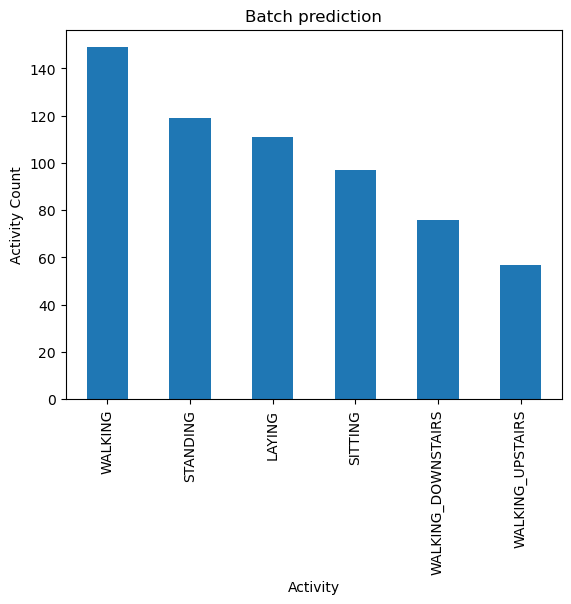

In [69]:
# Visualising the data distribution of the predicted activity column
import matplotlib.pyplot as plt
v1_prediction_df['label'].value_counts().plot(kind="bar", title="Batch prediction")
plt.xlabel("Activity")
plt.ylabel("Activity Count")

#### Prediction Evaluation

In [70]:
from sklearn.metrics import classification_report
print(classification_report(v1_test_y['Activity'].values,  v1_prediction_df['label']))


                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       111
           SITTING       0.91      0.89      0.90        99
          STANDING       0.88      0.92      0.90       114
           WALKING       0.77      0.90      0.83       126
WALKING_DOWNSTAIRS       0.89      0.94      0.92        72
  WALKING_UPSTAIRS       0.88      0.57      0.69        87

          accuracy                           0.88       609
         macro avg       0.89      0.87      0.87       609
      weighted avg       0.88      0.88      0.88       609



In [71]:
v1_test_data = v1_test_x
v1_test_data['label'] = v1_test_y['Activity']
v1_test_data['prediction'] =v1_prediction_df
v1_test_data.head()

,"angle(X,gravityMean)",tGravityAcc-mean()-X,tGravityAcc-energy()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,tGravityAcc-max()-Y,tBodyAcc-max()-X,tGravityAcc-mean()-Y,tGravityAcc-min()-Y,"angle(Y,gravityMean)",fBodyBodyAccJerkMag-entropy(),tGravityAcc-energy()-Y,label,prediction
0,-0.841247,0.963396,0.899469,0.892055,0.977436,-0.161265,-0.934724,-0.140840,-0.123213,0.179941,-1.0,-0.970905,STANDING,STANDING
1,-0.844788,0.966561,0.907829,0.892060,0.984520,-0.161343,-0.943068,-0.141551,-0.114893,0.180289,-1.0,-0.970583,STANDING,SITTING
2,-0.848933,0.966878,0.908668,0.892401,0.986770,-0.163711,-0.938692,-0.142010,-0.114893,0.180637,-1.0,-0.970368,STANDING,STANDING
3,-0.848649,0.967615,0.910621,0.893817,0.986821,-0.163711,-0.938692,-0.143976,-0.121336,0.181935,-1.0,-0.969400,STANDING,SITTING
4,-0.847865,0.968224,0.912235,0.893817,0.987434,-0.166786,-0.942469,-0.148750,-0.121834,0.185151,-1.0,-0.967051,STANDING,SITTING


## V2

In [77]:
v2_test_x, v2_test_y = preprocess_data(v2_test_data_path,cols)
v2_result = real_time_prediction(v2_test_x, endpoint_name)
v2_prediction_df = pd.DataFrame()
v2_prediction_df['label']= encoder.inverse_transform(v2_result)

(609, 12) (609, 1)


Text(0, 0.5, 'Activity Count')

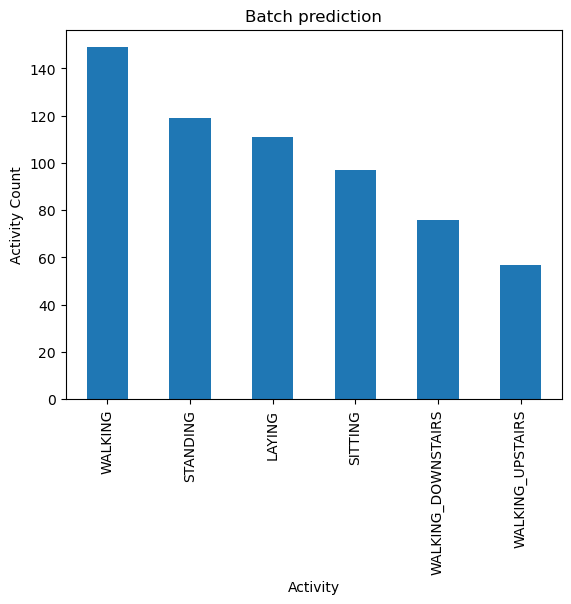

In [73]:
v2_prediction_df['label'].value_counts().plot(kind="bar", title="Batch prediction")
plt.xlabel("Activity")
plt.ylabel("Activity Count")

In [55]:
print(classification_report(v2_test_y['Activity'].values,  v2_prediction_df['label']))

                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       111
           SITTING       0.91      0.89      0.90        99
          STANDING       0.88      0.92      0.90       114
           WALKING       0.77      0.90      0.83       126
WALKING_DOWNSTAIRS       0.89      0.94      0.92        72
  WALKING_UPSTAIRS       0.88      0.57      0.69        87

          accuracy                           0.88       609
         macro avg       0.89      0.87      0.87       609
      weighted avg       0.88      0.88      0.88       609



In [56]:
v2_test_data = v2_test_x
v2_test_data['label'] = v2_test_y['Activity']
v2_test_data['prediction'] =v2_prediction_df
v2_test_data.head()

,"angle(X,gravityMean)",tGravityAcc-mean()-X,tGravityAcc-energy()-X,tGravityAcc-max()-X,tGravityAcc-min()-X,tGravityAcc-max()-Y,tBodyAcc-max()-X,tGravityAcc-mean()-Y,tGravityAcc-min()-Y,"angle(Y,gravityMean)",fBodyBodyAccJerkMag-entropy(),tGravityAcc-energy()-Y,label,prediction
0,-0.841247,0.963396,0.899469,0.892055,0.977436,-0.161265,-0.934724,-0.140840,-0.123213,0.179941,-1.0,-0.970905,STANDING,STANDING
1,-0.844788,0.966561,0.907829,0.892060,0.984520,-0.161343,-0.943068,-0.141551,-0.114893,0.180289,-1.0,-0.970583,STANDING,SITTING
2,-0.848933,0.966878,0.908668,0.892401,0.986770,-0.163711,-0.938692,-0.142010,-0.114893,0.180637,-1.0,-0.970368,STANDING,STANDING
3,-0.848649,0.967615,0.910621,0.893817,0.986821,-0.163711,-0.938692,-0.143976,-0.121336,0.181935,-1.0,-0.969400,STANDING,SITTING
4,-0.847865,0.968224,0.912235,0.893817,0.987434,-0.166786,-0.942469,-0.148750,-0.121834,0.185151,-1.0,-0.967051,STANDING,SITTING


In [57]:
v1_prediction_path = f's3://{bucket}/{prefix}/data_drift_check_data/output/v1/v1_data.csv'
v1_test_data.to_csv(v1_prediction_path, index =False)

In [58]:
v2_prediction_path = f's3://{bucket}/{prefix}/data_drift_check_data/output/v2/v2_data.csv'
v2_test_data.to_csv(v2_prediction_path, index =False)